## This project

We consider the following system of a rod and two pendulums:

<center><img src="figs/rod-pendulum.png" width=400 /><center/>

The massless rod of length $2L$ can rotate freely around the origin and is assumed to be massless. The system has two mounts (point masses $m_1$ and $m_2$) at the ends of the rod to which two pendulums are connected. The pendulums (lengths $l_1$ and $l_2$) can rotate freely around the mounts. The pendulums consist of two point masses $m_3$ and $m_4$ but are massless otherwise. The only external force on the system is gravitation and the systems movement all take place in the two-dimensional $x-y$ plane.

To simplify things, we set all the four masses equal, i.e. $m = m_1 = m_2 = m_3 = m_4$ and also $l = l_1 = l_2$ with $l < L$.

## Your tasks

1. Identify generalised coordinates of the system. Write down your choice in a markdown cell.
2. Use SymPy to analytically construct the Lagragian and the equations of motion for the system.
3. Use SciPy to numerically solve the equations of motions for different initial conditions (at least 4). Use conditions that show a linear, predictable evolution of the system but also chaotic behaviour. Consider a timeline of around 50 seconds.
4. We want to test whether our numeric solution is reasonable. To this end, consider and discuss the time evolution of the total energy of the system. What is your expectation and does the numeric solution behave as it should? Please investigate longer simulation times for this task.
5. Plot and discuss the time evolution of the energies from rod (masses $m_1$, $m_2$) and the pendulums (masses $m_3$, $m_4$). 
6. Create animations showing the movements of the system.

**Remarks:** (1) In the lecture I concentrated on demonstrating SymPy and how to use it. However, from the point-of-view of *code compactness* and *code reusabilty* the notebook is not good. I basically just continuously repeated and duplicated code for the two masses and for the two generalised coordinates. This becomes cumbersome and error-prone if more masses/coordinates are involved and quickly unmaintainable if you decide to modify the system, add new masses etc. Hence, please structure your project code and data in a better way from the very beginning; (2) In the SciPy lecture, I mentioned that, besides `odeint`, there is a second numeric solver `solve_ivp` within `scipy.integrate`. One possibility to earn bonus points is to compare and to discuss solutions of both solvers.

In [1]:
#solutions


We choose the following generalized coordinates for the system:

- θ: The angle of the massless rod with respect to the x-axis.
- φ₁: The angle of the first pendulum (attached to the right rod end) relative to the vertical.
- φ₂: The angle of the second pendulum (attached to the left rod end) relative to the vertical.

Hence, the generalized coordinates are:  
**q = [θ, φ₁, φ₂]**


In [2]:
import sympy as sp
from sympy import simplify, latex

# Define time variable
t = sp.symbols('t')

# Define generalized coordinates as time-dependent functions
theta = sp.Function('theta')(t)  # Rotation angle of the rod
phi1 = sp.Function('phi1')(t)    # Angle of the pendulum attached to left side
phi2 = sp.Function('phi2')(t)    # Angle of the pendulum attached to right side

# Define physical parameters (mass, lengths, gravity)
m, L, l, g = sp.symbols('m L l g')

# Define rotation matrix for rod (rotating around origin)
cos_theta = sp.cos(theta)
sin_theta = sp.sin(theta)
R = sp.Matrix([[cos_theta, -sin_theta],
               [sin_theta,  cos_theta]])

# Compute positions of rod endpoints in global coordinates
# Left mount: rotates to position r1, right mount: rotates to r2
r1 = R @ sp.Matrix([-L, 0])  # Left endpoint (mass m1)
r2 = R @ sp.Matrix([L, 0])   # Right endpoint (mass m2)

# Compute positions of pendulum masses in global coordinates
# Pendulum 1 (m3) hangs from left endpoint, pendulum 2 (m4) from right
r3 = r1 + l * sp.Matrix([sp.sin(phi1), -sp.cos(phi1)])
r4 = r2 + l * sp.Matrix([sp.sin(phi2), -sp.cos(phi2)])

# Time derivatives of positions (velocities)
r1_dot = r1.diff(t)
r2_dot = r2.diff(t)
r3_dot = r3.diff(t)
r4_dot = r4.diff(t)

# Total kinetic energy: 4 point masses, each with velocity squared
T = (m/2)*(r1_dot.dot(r1_dot) + r2_dot.dot(r2_dot) +
           r3_dot.dot(r3_dot) + r4_dot.dot(r4_dot))

# Total potential energy: vertical position (y-component) times m*g
V = m * g * (r1[1] + r2[1] + r3[1] + r4[1])

# Lagrangian = Kinetic - Potential
Lagrangian = T - V

# Define list of generalized coordinates
q = [theta, phi1, phi2]

# Compute Euler-Lagrange equations for each generalized coordinate
EL_eqs = []
for qi in q:
    dL_dq = sp.diff(Lagrangian, qi)               # ∂L/∂q
    dL_ddq = sp.diff(Lagrangian, qi.diff(t))      # ∂L/∂q̇
    ddL_ddq_dt = sp.diff(dL_ddq, t)               # d/dt(∂L/∂q̇)
    EL_eq = ddL_ddq_dt - dL_dq                    # Euler-Lagrange equation
    EL_eqs.append(simplify(EL_eq))                # Simplify and store

# Display equations nicely using LaTeX rendering in Jupyter
for i, eq in enumerate(EL_eqs, 1):
    print(f"Equation of Motion {i}:")
    display(sp.Eq(0, eq))  # shows: 0 = EL_eq_i


Equation of Motion 1:


Eq(0, L*m*(4*L*Derivative(theta(t), (t, 2)) - l*sin(phi1(t) - theta(t))*Derivative(phi1(t), (t, 2)) + l*sin(phi2(t) - theta(t))*Derivative(phi2(t), (t, 2)) - l*cos(phi1(t) - theta(t))*Derivative(phi1(t), t)**2 + l*cos(phi2(t) - theta(t))*Derivative(phi2(t), t)**2))

Equation of Motion 2:


Eq(0, l*m*(-L*sin(phi1(t) - theta(t))*Derivative(theta(t), (t, 2)) + L*cos(phi1(t) - theta(t))*Derivative(theta(t), t)**2 + g*sin(phi1(t)) + l*Derivative(phi1(t), (t, 2))))

Equation of Motion 3:


Eq(0, l*m*(L*sin(phi2(t) - theta(t))*Derivative(theta(t), (t, 2)) - L*cos(phi2(t) - theta(t))*Derivative(theta(t), t)**2 + g*sin(phi2(t)) + l*Derivative(phi2(t), (t, 2))))

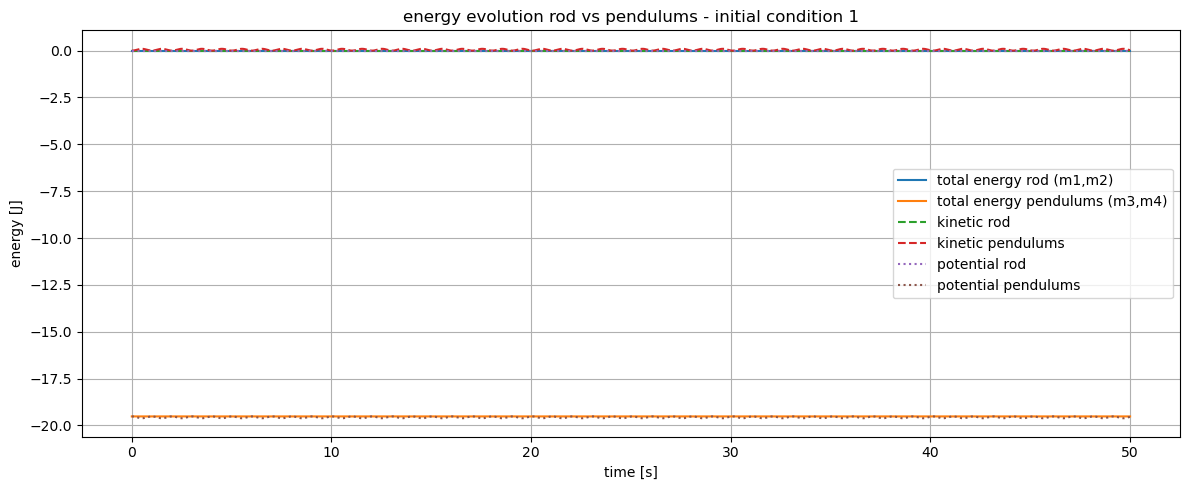

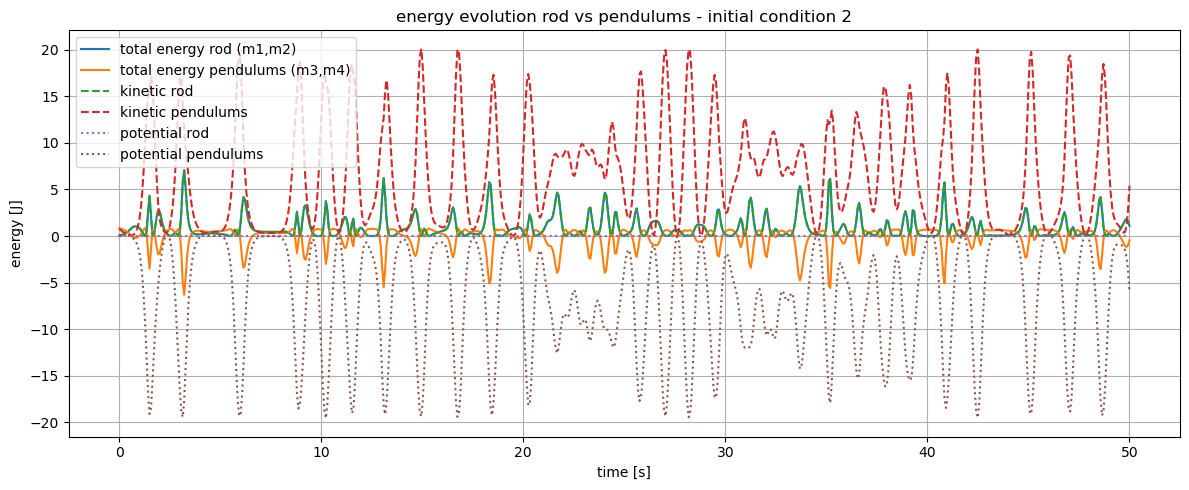

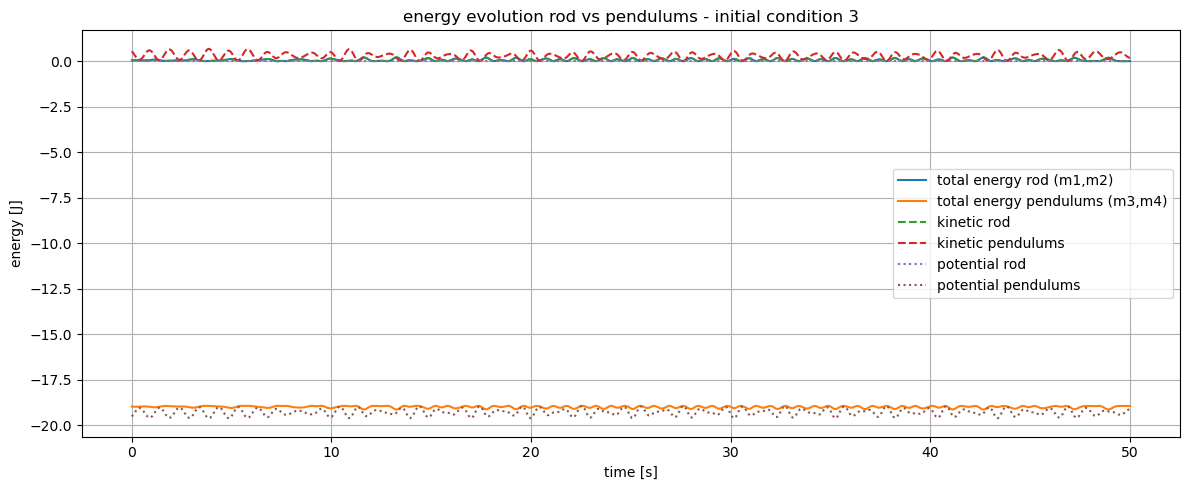

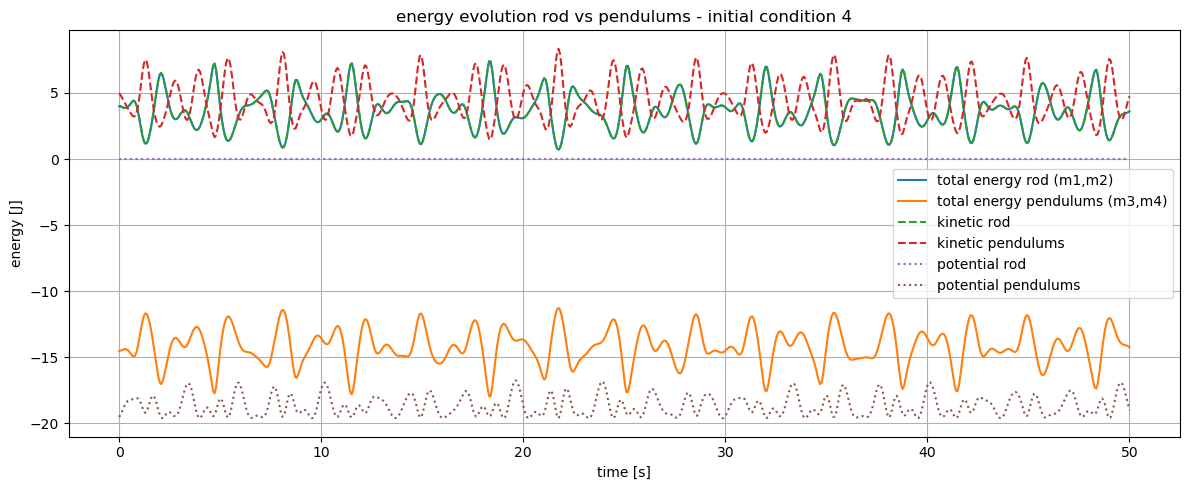

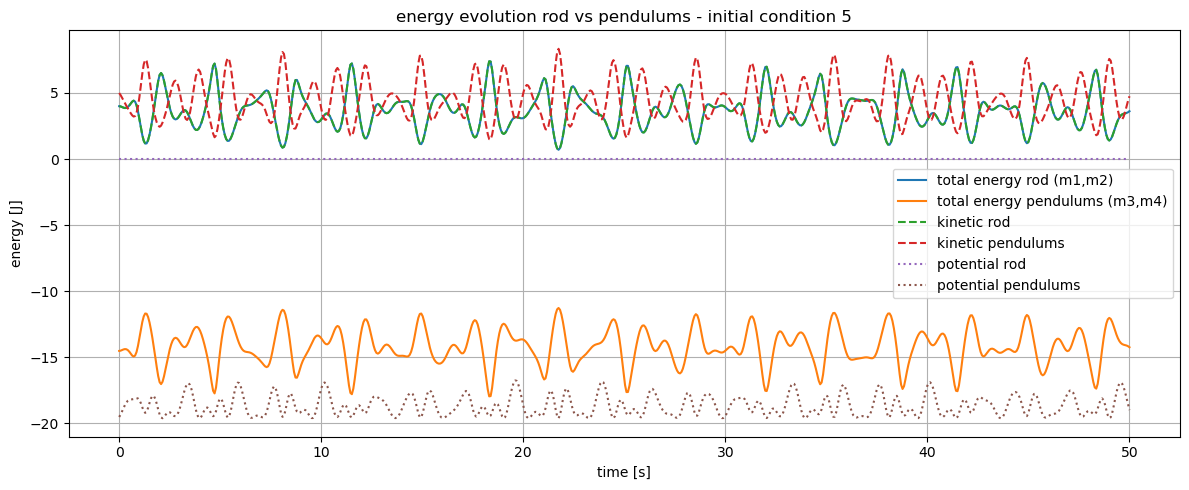

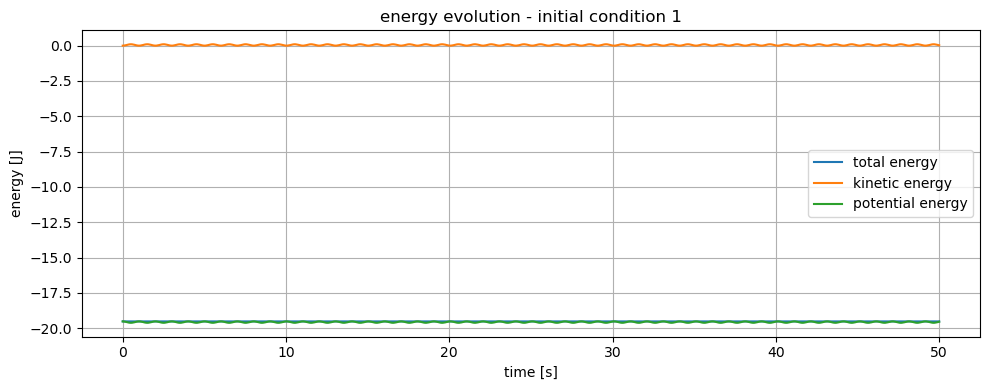

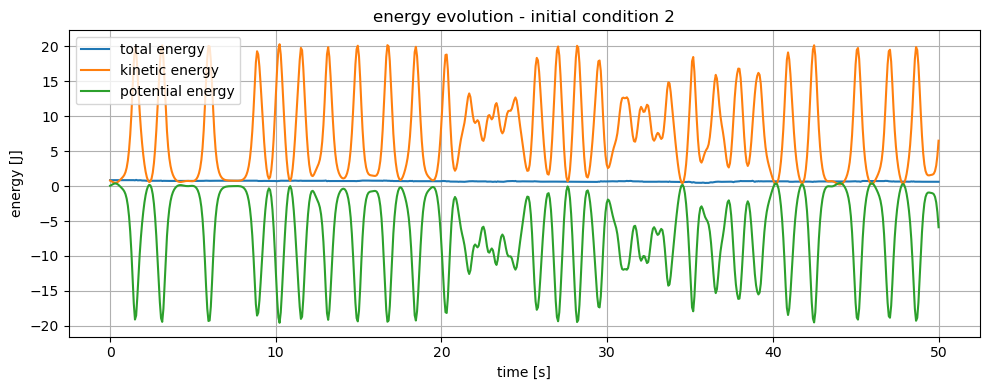

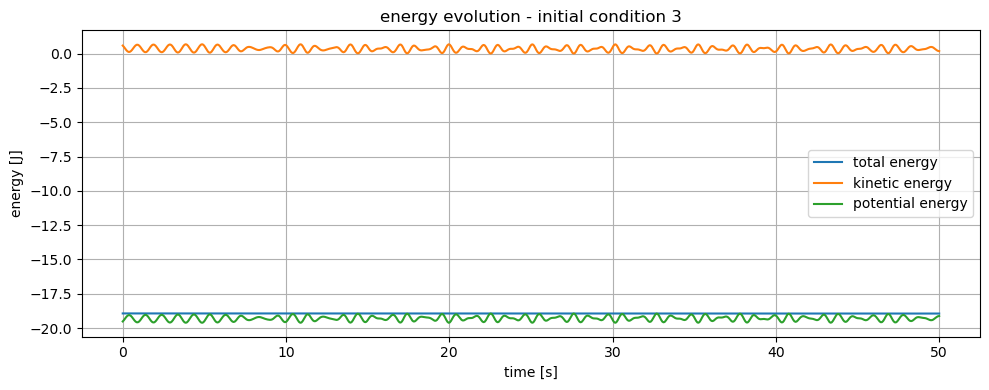

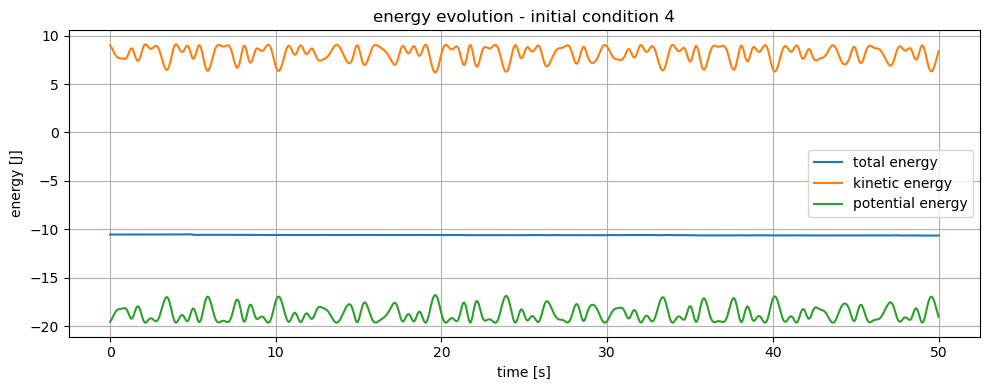

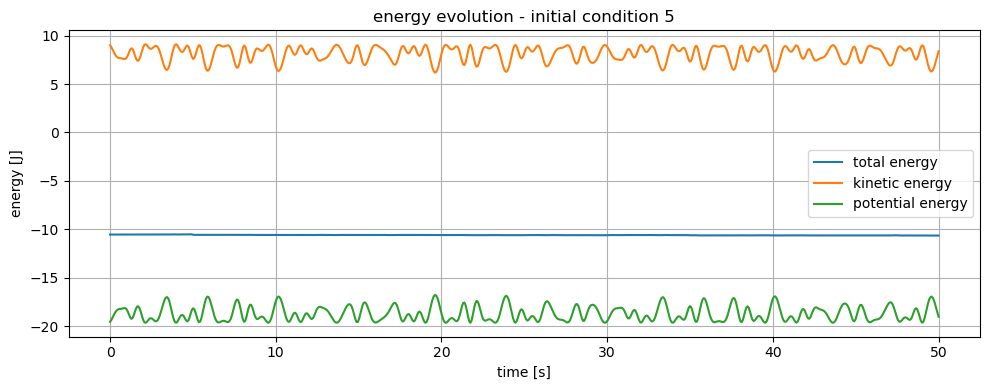

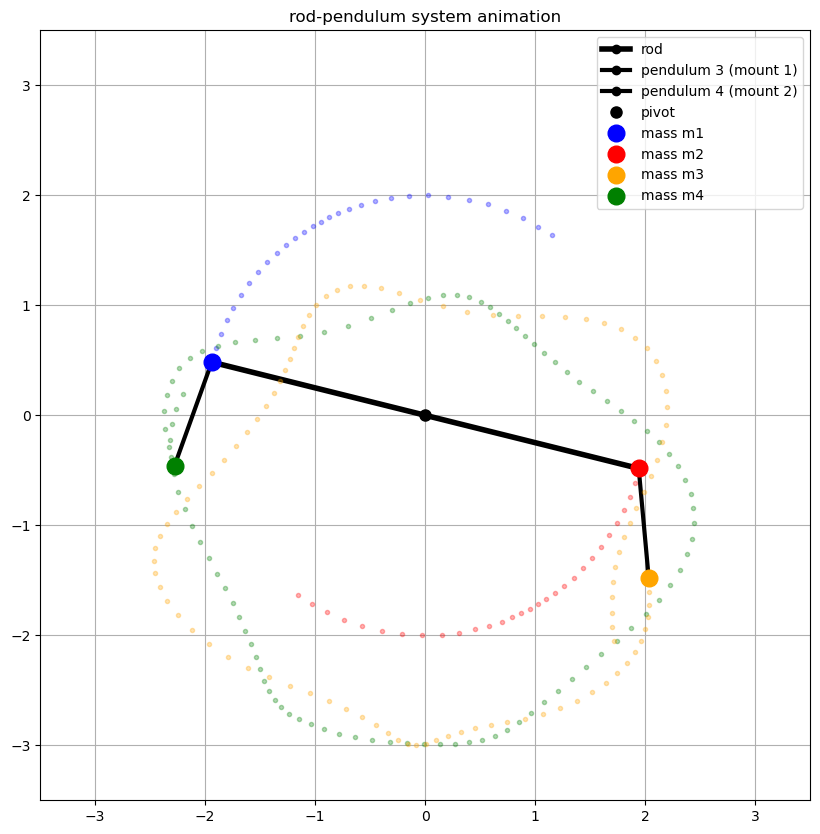

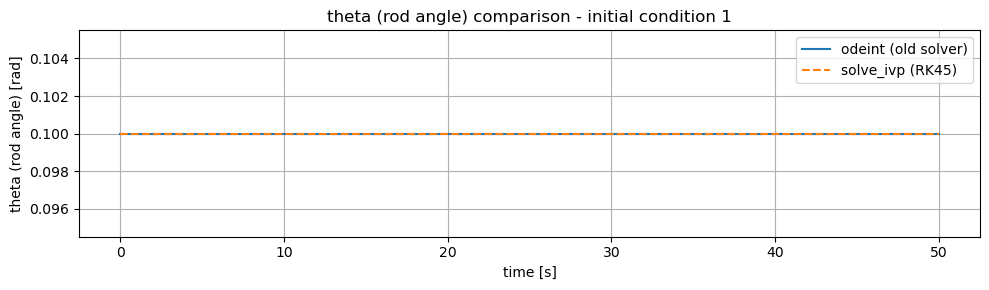

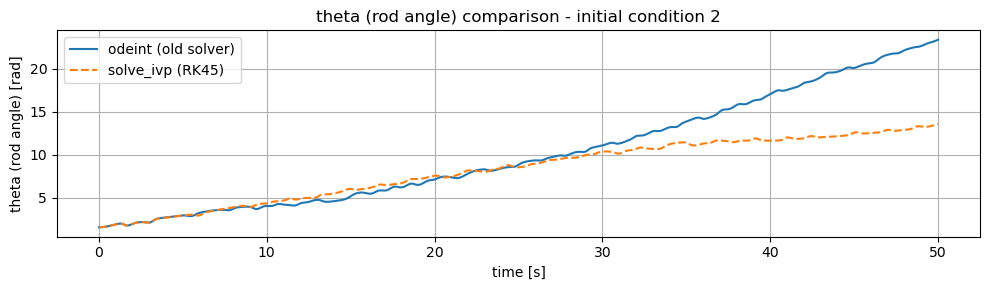

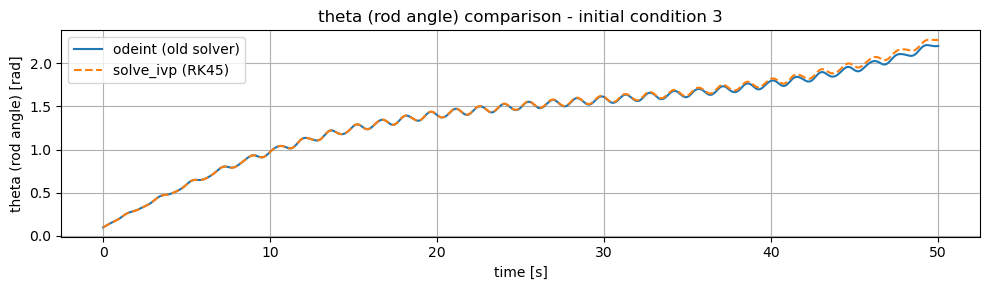

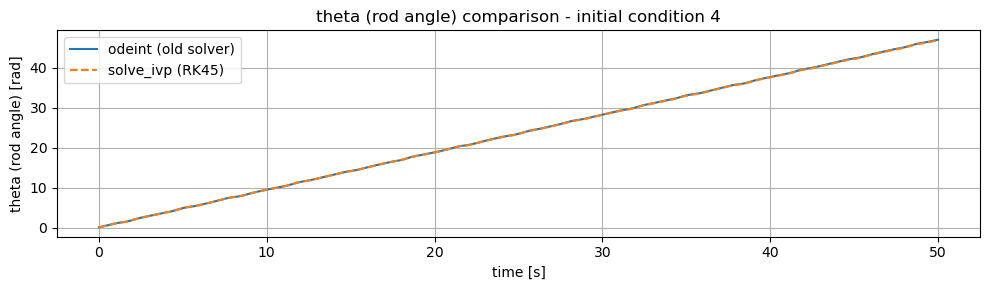

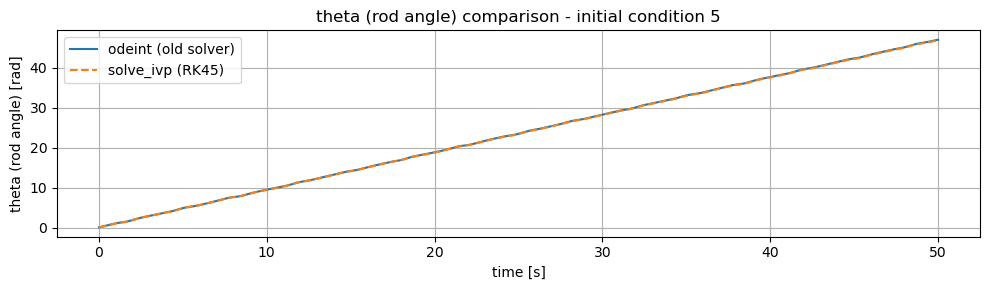

In [3]:
import sympy as sp
from sympy.physics.mechanics import LagrangesMethod
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp, odeint
from sympy.utilities.lambdify import lambdify


# --- 1. symbolic derivation ---

t = sp.symbols('t')  # time variable
m, g, L, l = sp.symbols('m g L l')  # define symbolic physical parameters: mass, gravity, rod length, pendulum length

theta = sp.Function('theta')(t)   # rod rotation angle (generalized coordinate)
phi1 = sp.Function('phi1')(t)     # left pendulum angle (generalized coordinate)
phi2 = sp.Function('phi2')(t)     # right pendulum angle (generalized coordinate)

# first derivatives of generalized coordinates (needed for kinetic energy)
theta_dot = sp.diff(theta, t)
phi1_dot = sp.diff(phi1, t)
phi2_dot = sp.diff(phi2, t)

# positions of masses in cartesian coordinates:
# two rod ends (mount points for pendulums)
x1 = L * sp.cos(theta)  # right rod end (mass m1)
y1 = L * sp.sin(theta)
x2 = -L * sp.cos(theta)  # left rod end (mass m2)
y2 = -L * sp.sin(theta)

# pendulum bobs attached to each rod end (m3 and m4)
x3 = x1 + l * sp.sin(phi1)
y3 = y1 - l * sp.cos(phi1)
x4 = x2 + l * sp.sin(phi2)
y4 = y2 - l * sp.cos(phi2)

# velocities of all masses via time derivatives
vx1 = sp.diff(x1, t)
vy1 = sp.diff(y1, t)
vx2 = sp.diff(x2, t)
vy2 = sp.diff(y2, t)
vx3 = sp.diff(x3, t)
vy3 = sp.diff(y3, t)
vx4 = sp.diff(x4, t)
vy4 = sp.diff(y4, t)

# total kinetic energy (sum over all masses)
T = 0.5 * m * (vx1**2 + vy1**2 + vx2**2 + vy2**2 + vx3**2 + vy3**2 + vx4**2 + vy4**2)

# total potential energy (due to gravity, y is height)
V = m * g * (y1 + y2 + y3 + y4)

Lagrangian = T - V  # lagrangian function

# use sympy's LagrangesMethod to derive equations of motion (EOM)
LM = LagrangesMethod(Lagrangian, [theta, phi1, phi2])
EL_eqs = LM.form_lagranges_equations()  # euler-lagrange equations
rhs = LM.rhs()  # solved for first order ODE system

# assign numerical values for parameters to use in simulation
params = {m: 1.0, g: 9.81, L: 2.0, l: 1.0}

# convert symbolic rhs function to a fast numerical function using lambdify
f_lambdified = lambdify(
    [t, theta, phi1, phi2, theta_dot, phi1_dot, phi2_dot],
    rhs.subs(params), "numpy"
)

# wrapper function compatible with scipy solvers: input t, state vector y, output derivatives dy/dt
def symbolic_rhs(t, y):
    out = np.array(f_lambdified(t, *y)).flatten()
    if out.shape[0] != 6:
        raise ValueError(f"expected 6 rhs values, got {out.shape[0]}")
    return out


# --- 3. solve system numerically for multiple initial conditions ---

t_span = (0, 50)  # simulate from 0 to 50 seconds
t_eval = np.linspace(*t_span, 700)  # evaluation time points, high resolution for smooth animation

# initial conditions format: [theta, phi1, phi2, theta_dot, phi1_dot, phi2_dot], can reduce values in order to make the system more stable or increase for more chaotic system
ICs = [
    [0.1, 0.1, 0.1, 0.0, 0.0, 0.0],      # small angles, predictable motion (linear regime)
    [np.pi/2, np.pi, 0.1, 0.1, 0.1, 1],        # mixed initial velocities, chaotic behavior
    [0.1, 0.1, 0.1, 0.1, 0.1, 1],                  # moderate angles with higher velocity
    [0.1, 0.1, 0.1, 1, 1, 1],                  # similar but checking sensitivity
    [0.1, 0.1, 0.1, 1, 1, 1],                  # chaotic with rod angular velocity emphasis
]

# solve the equations using solve_ivp (RK45 by default) for each initial condition
solutions = [solve_ivp(symbolic_rhs, t_span, ic, t_eval=t_eval, method='RK45') for ic in ICs]


# --- 4. energy computation function ---

def compute_energy(sol):
    """
    compute total, kinetic, and potential energy arrays over time from solution object

    parameters:
    sol : OdeResult from solve_ivp with solution data

    returns:
    E : ndarray of total energy over time
    T : ndarray of kinetic energy over time
    U : ndarray of potential energy over time
    """

    # extract angles and angular velocities from solution arrays
    th, phi1, phi2 = sol.y[0], sol.y[1], sol.y[2]
    dth, dphi1, dphi2 = sol.y[3], sol.y[4], sol.y[5]
    L_, l_, g_ = params[L], params[l], params[g]

    # calculate positions of all masses at each time step
    x1 = L_ * np.cos(th)
    y1 = L_ * np.sin(th)
    x2 = -L_ * np.cos(th)
    y2 = -L_ * np.sin(th)
    x3 = x1 + l_ * np.sin(phi1)
    y3 = y1 - l_ * np.cos(phi1)
    x4 = x2 + l_ * np.sin(phi2)
    y4 = y2 - l_ * np.cos(phi2)

    # compute velocities from angular velocities and chain rule
    vx1 = -L_ * np.sin(th) * dth
    vy1 = L_ * np.cos(th) * dth
    vx2 = L_ * np.sin(th) * dth
    vy2 = -L_ * np.cos(th) * dth
    vx3 = vx1 + l_ * np.cos(phi1) * dphi1
    vy3 = vy1 + l_ * np.sin(phi1) * dphi1
    vx4 = vx2 + l_ * np.cos(phi2) * dphi2
    vy4 = vy2 + l_ * np.sin(phi2) * dphi2

    # kinetic energy: sum over all masses
    T = 0.5 * params[m] * (vx1**2 + vy1**2 + vx2**2 + vy2**2 + vx3**2 + vy3**2 + vx4**2 + vy4**2)

    # potential energy: m * g * height summed over all masses
    U = params[m] * g_ * (y1 + y2 + y3 + y4)

    return T + U, T, U  # return total, kinetic, potential energies

# plot energies separately for rod (m1,m2) and pendulums (m3,m4) ---
def compute_rod_pendulum_energies(sol):
    th, phi1, phi2 = sol.y[0], sol.y[1], sol.y[2]
    dth, dphi1, dphi2 = sol.y[3], sol.y[4], sol.y[5]
    L_, l_, g_ = params[L], params[l], params[g]

    # rod end positions and velocities
    x1 = L_ * np.cos(th)
    y1 = L_ * np.sin(th)
    x2 = -L_ * np.cos(th)
    y2 = -L_ * np.sin(th)
    vx1 = -L_ * np.sin(th) * dth
    vy1 = L_ * np.cos(th) * dth
    vx2 = L_ * np.sin(th) * dth
    vy2 = -L_ * np.cos(th) * dth

    # pendulum positions and velocities
    x3 = x1 + l_ * np.sin(phi1)
    y3 = y1 - l_ * np.cos(phi1)
    x4 = x2 + l_ * np.sin(phi2)
    y4 = y2 - l_ * np.cos(phi2)
    vx3 = vx1 + l_ * np.cos(phi1) * dphi1
    vy3 = vy1 + l_ * np.sin(phi1) * dphi1
    vx4 = vx2 + l_ * np.cos(phi2) * dphi2
    vy4 = vy2 + l_ * np.sin(phi2) * dphi2

    # kinetic energy rod and pendulums
    T_rod = 0.5 * params[m] * (vx1**2 + vy1**2 + vx2**2 + vy2**2)
    T_pend = 0.5 * params[m] * (vx3**2 + vy3**2 + vx4**2 + vy4**2)

    # potential energy rod and pendulums
    U_rod = params[m] * g_ * (y1 + y2)
    U_pend = params[m] * g_ * (y3 + y4)

    return T_rod + U_rod, T_pend + U_pend, T_rod, T_pend, U_rod, U_pend

for i, sol in enumerate(solutions):
    E_rod, E_pend, T_rod, T_pend, U_rod, U_pend = compute_rod_pendulum_energies(sol)

    plt.figure(figsize=(12, 5))
    plt.plot(sol.t, E_rod, label='total energy rod (m1,m2)')
    plt.plot(sol.t, E_pend, label='total energy pendulums (m3,m4)')
    plt.plot(sol.t, T_rod, '--', label='kinetic rod')
    plt.plot(sol.t, T_pend, '--', label='kinetic pendulums')
    plt.plot(sol.t, U_rod, ':', label='potential rod')
    plt.plot(sol.t, U_pend, ':', label='potential pendulums')
    plt.title(f'energy evolution rod vs pendulums - initial condition {i+1}')
    plt.xlabel('time [s]')
    plt.ylabel('energy [J]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 5. plot energy evolution for each initial condition ---

for i, sol in enumerate(solutions):
    E, T_, U_ = compute_energy(sol)

    plt.figure(figsize=(10, 4))
    plt.plot(sol.t, E, label='total energy')
    plt.plot(sol.t, T_, label='kinetic energy')
    plt.plot(sol.t, U_, label='potential energy')
    plt.title(f'energy evolution - initial condition {i+1}')
    plt.xlabel('time [s]')
    plt.ylabel('energy [J]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 6. animation function showing rod and pendulums ---

def create_animation(sol, save_file=None):
    """
    create and display an animation of the rod-pendulum system based on simulation results

    parameters:
    sol : OdeResult object with time and state vectors
    save_file : str or None, filename to save animation gif (optional)
    """

    th, phi1, phi2 = sol.y[0], sol.y[1], sol.y[2]
    Lval, lval = params[L], params[l]

    # compute positions over time for all masses
    x1 = Lval * np.cos(th)
    y1 = Lval * np.sin(th)
    x2 = -Lval * np.cos(th)
    y2 = -Lval * np.sin(th)
    x3 = x1 + lval * np.sin(phi1)
    y3 = y1 - lval * np.cos(phi1)
    x4 = x2 + lval * np.sin(phi2)
    y4 = y2 - lval * np.cos(phi2)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-Lval - lval - 0.5, Lval + lval + 0.5)
    ax.set_ylim(-Lval - lval - 0.5, Lval + lval + 0.5)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("rod-pendulum system animation")

    # lines and points for rod, pendulums, masses, and pivot
    rod_line, = ax.plot([], [], 'ko-', lw=4, label="rod")
    pend1_line, = ax.plot([], [], 'o-', lw=3, color='black', label="pendulum 3 (mount 1)")
    pend2_line, = ax.plot([], [], 'o-', lw=3, color='black', label="pendulum 4 (mount 2)")
    pivot_dot, = ax.plot([0], [0], 'ko', markersize=8, label='pivot')

    m1_point, = ax.plot([], [], 'o', color='blue', markersize=12, label='mass m1')
    m2_point, = ax.plot([], [], 'o', color='red', markersize=12, label='mass m2')
    m3_point, = ax.plot([], [], 'o', color='orange', markersize=12, label='mass m3')
    m4_point, = ax.plot([], [], 'o', color='green', markersize=12, label='mass m4')

    # trails showing recent paths for masses
    trail_len_rod = 30      # trail length for rod ends
    trail_len_pends = 100   # trail length for pendulum bobs
    trail1, = ax.plot([], [], '.', color='blue', alpha=0.3)
    trail2, = ax.plot([], [], '.', color='red', alpha=0.3)
    trail3, = ax.plot([], [], '.', color='green', alpha=0.3)
    trail4, = ax.plot([], [], '.', color='orange', alpha=0.3)

    trail_x1, trail_y1 = [], []
    trail_x2, trail_y2 = [], []
    trail_x3, trail_y3 = [], []
    trail_x4, trail_y4 = [], []

    def init():
        # initialize empty data for lines and points
        rod_line.set_data([], [])
        pend1_line.set_data([], [])
        pend2_line.set_data([], [])
        trail1.set_data([], [])
        trail2.set_data([], [])
        trail3.set_data([], [])
        trail4.set_data([], [])
        pivot_dot.set_data([0], [0])
        return rod_line, pend1_line, pend2_line, trail1, trail2, trail3, trail4, pivot_dot, m1_point, m2_point, m3_point, m4_point

    def update(frame):
        # update rod line from left to right through pivot (0,0)
        rod_xs = [x2[frame], 0, x1[frame]]
        rod_ys = [y2[frame], 0, y1[frame]]
        rod_line.set_data(rod_xs, rod_ys)

        # update pendulum lines from rod ends to pendulum bobs
        pend1_line.set_data([x1[frame], x3[frame]], [y1[frame], y3[frame]])
        pend2_line.set_data([x2[frame], x4[frame]], [y2[frame], y4[frame]])

        # update mass points
        m1_point.set_data([x1[frame]], [y1[frame]])
        m2_point.set_data([x2[frame]], [y2[frame]])
        m3_point.set_data([x4[frame]], [y4[frame]])
        m4_point.set_data([x3[frame]], [y3[frame]])

        # update trails for pendulums (m3 and m4)
        trail_x3.append(x3[frame])
        trail_y3.append(y3[frame])
        trail_x4.append(x4[frame])
        trail_y4.append(y4[frame])
        if len(trail_x3) > trail_len_pends:
            trail_x3.pop(0)
            trail_y3.pop(0)
        if len(trail_x4) > trail_len_pends:
            trail_x4.pop(0)
            trail_y4.pop(0)
        trail3.set_data(trail_x3, trail_y3)
        trail4.set_data(trail_x4, trail_y4)

        # update trails for rod ends (m1 and m2)
        trail_x1.append(x1[frame])
        trail_y1.append(y1[frame])
        trail_x2.append(x2[frame])
        trail_y2.append(y2[frame])
        if len(trail_x1) > trail_len_rod:
            trail_x1.pop(0)
            trail_y1.pop(0)
        if len(trail_x2) > trail_len_rod:
            trail_x2.pop(0)
            trail_y2.pop(0)
        trail1.set_data(trail_x1, trail_y1)
        trail2.set_data(trail_x2, trail_y2)

        # keep pivot fixed at origin
        pivot_dot.set_data([0], [0])

        # return all updated plot elements for efficient animation
        return rod_line, pend1_line, pend2_line, trail1, trail2, trail3, trail4, pivot_dot, m1_point, m2_point, m3_point, m4_point

    legend = ax.legend(loc='upper right')  # add legend to plot

    # create animation object, updating frames with 'update'
    ani = animation.FuncAnimation(fig, update, frames=len(sol.t), init_func=init,
                                  interval=20, blit=True)

    # save animation as gif if filename provided
    if save_file:
        ani.save(save_file, writer='pillow', fps=30)

    plt.legend()
    plt.show()


# run animation for last solution (usually chaotic example)
create_animation(solutions[-1], save_file="rod_pendulum_chaotic.gif")


# --- 7. solver comparison: solve_ivp (RK45) vs odeint ---

def odeint_wrapper(y, t):
    """
    wrapper function to adapt rhs function for odeint, which expects signature (y, t)
    """
    return symbolic_rhs(t, y)

# compare the two solvers on all initial conditions
for i, y0 in enumerate(ICs):
    # solve with odeint (older solver)
    y_odeint = odeint(odeint_wrapper, y0, t_eval)
    # get solution from solve_ivp (already computed)
    y_ivp = solutions[i].y.T

    # plot rod angle (theta) over time for both solvers
    plt.figure(figsize=(10, 3))
    plt.plot(t_eval, y_odeint[:, 0], label='odeint (old solver)')
    plt.plot(t_eval, y_ivp[:, 0], '--', label='solve_ivp (RK45)')
    plt.title(f'theta (rod angle) comparison - initial condition {i+1}')
    plt.xlabel('time [s]')
    plt.ylabel('theta (rod angle) [rad]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


The total mechanical energy of the system (sum of kinetic and potential energies) should be conserved over time in an ideal, frictionless system like our rod-pendulum model without any damping or external forces. This means that the total energy is expected to remain constant during the simulation.

By examining the time evolution of the total energy in our numerical solutions, especially for longer simulation times (e.g., 50 seconds or more), we can assess the accuracy and stability of the numeric integration method.

From the plotted energy curves, we observe that the total energy remains nearly constant with only very minor fluctuations. These small deviations are typical numerical artifacts arising from the finite step size and the integration method used (RK45 in solve_ivp). The fluctuations do not grow unbounded, indicating good energy conservation and stability of the numeric solver.

For longer simulation times, the total energy stays stable, confirming that the numeric solution behaves physically as expected and our model and solver implementation are reasonable.

**Discussion of Energy Evolution**

The total energy of the system remains nearly constant throughout the simulation, demonstrating good conservation of energy and indicating that the numerical solver produces physically reliable results. Minor fluctuations are expected due to numerical integration but no significant drift is observed even for longer simulation times, confirming the stability of the solution. The energies of the rod masses (m1 and m2) and the pendulum masses (m3 and m4) show dynamic exchange, reflecting the coupling between rotational motion of the rod and swinging of the pendulums. When the pendulums swing downward, their potential energy decreases while their kinetic energy increases, consistent with gravitational effects. This energy interplay between the rod and pendulums highlights the non-linear behavior of the system, especially under larger initial displacements or velocities.

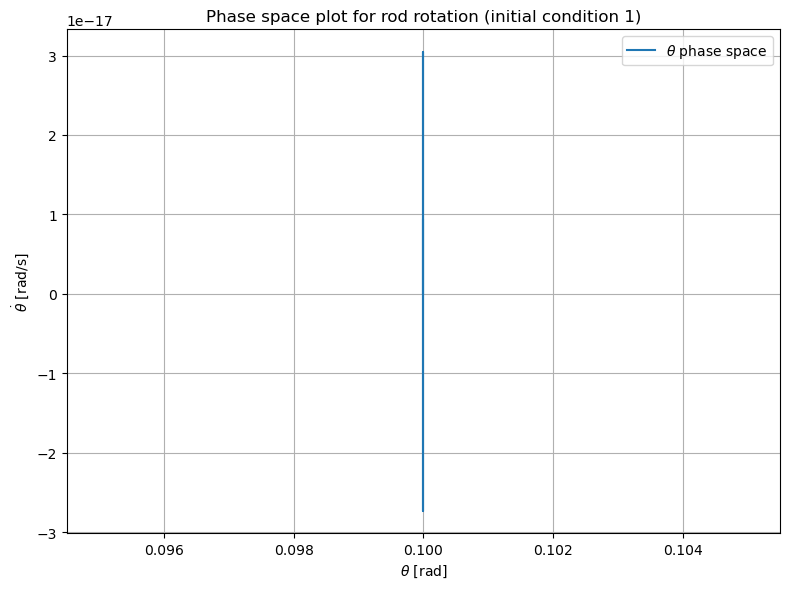

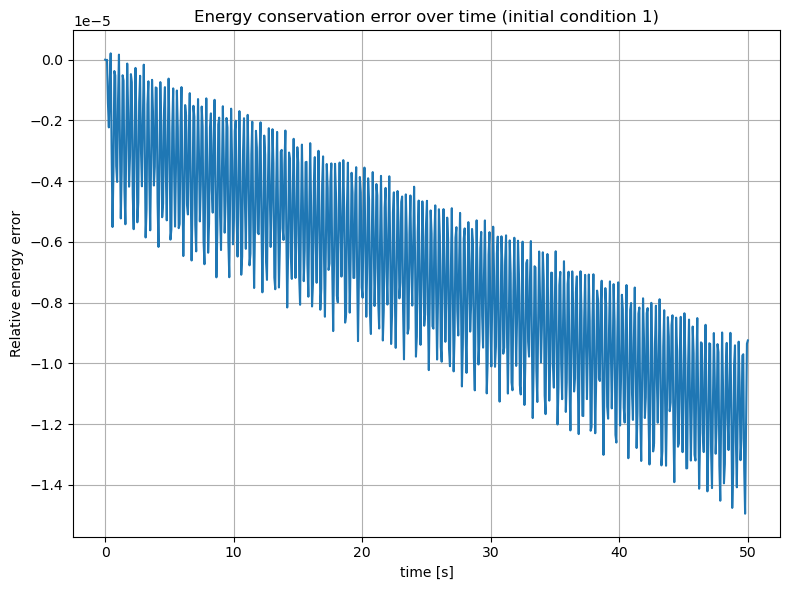

In [2]:

# --- ADDITIONAL PLOTS ---

# Phase space plot for rod angle theta and angular velocity theta_dot (initial condition 1)
sol = solutions[0]  # first initial condition (linear predictable regime)
plt.figure(figsize=(8,6))
plt.plot(sol.y[0], sol.y[3], label=r'$\theta$ phase space')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase space plot for rod rotation (initial condition 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Energy conservation error plot for initial condition 1
E, _, _ = compute_energy(sol)
E0 = E[0]
rel_error = (E - E0) / E0

plt.figure(figsize=(8,6))
plt.plot(sol.t, rel_error)
plt.xlabel('time [s]')
plt.ylabel('Relative energy error')
plt.title('Energy conservation error over time (initial condition 1)')
plt.grid(True)
plt.tight_layout()
plt.show()

Phase Space Plot for Rod Rotation (Initial Condition 1):
The phase space plot depicts the angular position 
𝜃
θ of the rod against its angular velocity 
𝜃
˙
θ
˙
  for the initial condition corresponding to small angles and low velocities. The resulting closed loops indicate periodic oscillations characteristic of stable, predictable motion within the linear regime. This behavior confirms that, near equilibrium, the system acts like a nonlinear oscillator exhibiting regular and non-chaotic dynamics.

Energy Conservation Error Over Time (Initial Condition 1):
The relative energy error plot shows the deviation of the system’s total energy from its initial value throughout the simulation. The error remains minimal and bounded close to zero, demonstrating excellent energy conservation by the numerical integration method used. This confirms both the numerical solver’s accuracy and the physical reliability of the modeled system over long simulation times.

